In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import stats

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

The following lines need to be used if data the from downloaded dataset should be used. The location of the ``Data`` folder needs to be specified by the parameter ``DATA_FOLDER_PATH`` in the file ``input_params.json``. 

If you want to analyse your own dataset you need to set the variable ``file_path`` to the folder where the simulation is located. Importantly, in this folder there should only be located exactly one simulation.

In [3]:
file_path_input_params_json = '../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'fig_4/Fig_4A'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Documents/Arbeit/PhD/data/UltrasensitivityCombined/NatCom/fig_4/Fig_4A
parameter_path /home/berger/Documents/Arbeit/PhD/data/UltrasensitivityCombined/NatCom/fig_4/Fig_4A/parameter_set.csv


In [4]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)
colors = [blue, pinkish_red, green, dark_blue, yellow]

n_bins = 20
n_min_per_bin = 15

# Random error

In [6]:
data_frame = makeDataframe.make_dataframe(file_path)
data_frame = makeDataframe.add_average_values_to_df(data_frame)
data_frame = makeDataframe.add_theoretical_init_reg_concentrations_to_df(data_frame)

['/home/berger/Documents/Arbeit/PhD/data/UltrasensitivityCombined/results/paper/Fig_5A/LD_lipids_delta_5000.pdf',
 '/home/berger/Documents/Arbeit/PhD/data/UltrasensitivityCombined/results/paper/Fig_5A/LD_lipids_5000',
 '/home/berger/Documents/Arbeit/PhD/data/UltrasensitivityCombined/results/paper/Fig_5A/LD_lipids_delta.pdf']


## Plot correlation added initiation volume with initiation volume

In [7]:
def return_array_of_initiation_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init']

def return_array_of_initiation_and_birth_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init'], data_frame['v_b_before_init']

In [8]:
import scipy.stats

def return_sem(np_array):
#     print('np_array', np_array)
    if np_array.size == 0:
#         print('size of np array in return_sem was zero')
        return np.nan
    else:
        df = pd.DataFrame(data=np_array)
#         print('df', df)
#         print('sem', df.sem())
        return df.sem()

def given_dataframe_return_bins_with_mean_sem(data_frame, data_x, data_y, n_bins, n_min_per_bin):
    x_max = data_frame[data_x].max()
    x_min = data_frame[data_x].min()
    bin_np, bin_pos = np.histogram(data_frame[data_x], bins=np.linspace(x_min, x_max, n_bins))
    minpos = bin_pos[np.where(bin_np>n_min_per_bin)[0][0]]
    maxpos = bin_pos[np.where(bin_np>n_min_per_bin)[0][-1]]
    return fig_data[(fig_data.data_x>minpos)&(fig_data.data_x<maxpos)]

def return_label_relaxation_rate(relaxation_rate, correlation):
    return r'$\theta$= {}, R= {} '.format(np.round(relaxation_rate, 3),
                                        np.round(correlation, 3))
def return_label_number_samples(number, correlation):
    return r'N= {}, R= {} '.format(np.round(number, 3),
                                        np.round(correlation, 3))

mean: 0.2913334422789667 std: 0.012607837932387268 CV: 0.043276315392294096
Leght of data frame: 998
[ 10.  52. 159. 243. 253. 151.  88.  30.   9.   3.]


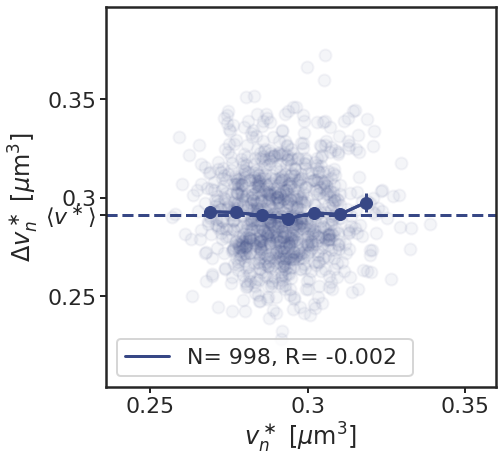

In [9]:
sns.set(style="white")
sns.set_context("poster")
sns.set_style("ticks")
df_correlations = []
data_frame = data_frame.sort_values(by=['relaxation_rate'])

for index, row in data_frame.iterrows():
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    print('mean:', np.mean(v_init_np), 'std:', np.std(v_init_np), 'CV:', np.std(v_init_np)/np.mean(v_init_np))
    df_item = pd.DataFrame({"v_init" : v_init_np[:-1],
                            "delta_v_init" : 2*v_init_np[1:]-v_init_np[:-1],
                            "relaxation_rate": row.relaxation_rate
                                   })
    df_item['correlation'] = df_item['v_init'].corr(df_item['delta_v_init'], method='pearson')
    df_item["color"] = df_item.apply(lambda row: colors[index], axis=1)
    df_item["mean"] = df_item.apply(lambda row: np.mean(v_init_np), axis=1)
    print('Leght of data frame:', len(df_item.index))
    df_correlations.append(df_item)
    
fig, ax = plt.subplots(figsize=(7,7))
for df in df_correlations:
    # plot raw datter as scatter plot
    ax.scatter(df['v_init'], 
               df['delta_v_init'], 
               alpha=0.05, 
               color=df['color'][0])
    # bin data and plot mean and sem per bin
    bin_count, bin_edges, binnumber = stats.binned_statistic(df['v_init'], 
                                                         df['delta_v_init'], 
                                                         'count', 
                                                         bins=10)
    print(bin_count)
    bin_means, bin_edges, binnumber = stats.binned_statistic(df['v_init'], 
                                                             df['delta_v_init'], 
                                                             'mean', 
                                                             bins=10)
    
#     print('mean', bin_means)
    bin_sem, bin_edges, binnumber = stats.binned_statistic(df['v_init'], 
                                                             df['delta_v_init'], 
                                                             return_sem, 
                                                             bins=10)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_means_cut = bin_means[bin_count >=n_min_per_bin]
    bin_centers_cut = bin_centers[bin_count >=n_min_per_bin]
    bin_sem_cut = bin_sem[bin_count >=n_min_per_bin]

    ax.plot(bin_centers_cut, bin_means_cut, c=df['color'][0], label=return_label_number_samples(len(df.index),
                                                                          df['correlation'][0]))
    ax.errorbar(bin_centers_cut, bin_means_cut, yerr=bin_sem_cut, marker='o', c=df['color'][0])
    ax.axhline(df["mean"][0], linestyle='--', linewidth=3, color=blue)
    ax.plot()
    
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
ax.set_yticks([0.25, np.mean(v_init_np),  0.3, 0.35])
ax.set_yticklabels([   r'0.25',  r'$\langle v^\ast \rangle$', r'0.3', r'0.35'])  
ax.set_xticks([0.25,0.3, 0.35])
ax.set_xticklabels([ r'0.25',r'0.3', r'0.35'])    
# ax.set(ylim=(0.09,0.15))
# ax.set(xlim=(0.09,0.15))
ax.legend(loc='lower left')
ax.set(xlabel=r'$v^\ast_n$ [$\mu$m$^3$]', ylabel=r'$\Delta v^\ast_n$ [$\mu$m$^3$]')
plt.savefig(file_path + '/LD_lipids_delta.pdf', format='pdf', bbox_inches='tight')
    